In [1]:
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from mlagents_envs.environment import ActionTuple, UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import \
    EngineConfigurationChannel
from mlagents_envs.exception import (
    UnityEnvironmentException,
    UnityCommunicationException,
    UnityCommunicatorStoppedException,
)
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
import collections
from typing import Union, Tuple
import math
import random
from copy import deepcopy
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class NStepPriorityReplayBuffer:

    def __init__(
        self,
        max_size: int,
        prob_alpha: float = 0.6,
        beta_start: float = 0.4,
        beta_frames: float = 100000,
        n_step: int = 4,
        gamma: float = 0.99,
    ):
        self._prob_alpha = prob_alpha
        self._max_size = max_size
        self._pos = 0
        self._buf = []
        self._priorities = np.zeros((max_size,), dtype=np.float32)
        self._beta_start = beta_start
        self._beta = beta_start
        self._beta_frames = beta_frames
        self._n_step = n_step
        self._gamma = gamma
        self._total_discounted_rewards = np.array([np.nan]*max_size)
        self._last_states = [np.nan]*max_size

    def update_bata(self, idx) -> None:
        beta = self._beta_start + idx * (1.0 - self._beta_start) / self._beta_frames
        self._beta = min(1.0, beta)
        return self._beta

    def __len__(self):
        return len(self._buf)

    def append(
        self,
        state: np.ndarray,
        action: int,
        reward: Union[int, float],
        done: bool,
        next_state: np.ndarray,
    ) -> None:
        max_prio = self._priorities.max() if self._buf else 1.0
        if len(self._buf) < self._max_size:
            self._buf.append(
                (state, action, reward, done, next_state)
            )
        else:
            self._buf[self._pos] = (state, action, reward, done, next_state)
        self._priorities[self._pos] = max_prio

        if len(self._buf) >= self._n_step:
            dis_r = 0.0
            last_state = self._buf[self._pos][0]
            for i in range(self._n_step):
                state, _, r, done, _ = self._buf[self._pos - i]
                dis_r = r + self._gamma * dis_r
                if done:
                    last_state = state
                    dis_r = r  # ※
                self._total_discounted_rewards[self._pos - i] = dis_r
                self._last_states[self._pos - i] = last_state
            
            for i in range(self._n_step-1):
                done = self._buf[self._pos - i][3]
                if done:
                    break
                self._total_discounted_rewards[self._pos - i] = np.nan
                self._last_states[self._pos - i] = np.nan

        self._pos = (self._pos + 1) % self._max_size

    def sample(self, size: int):
        sample_target_indices = np.where(~np.isnan(self._total_discounted_rewards[:len(self._buf)]))[0]
        # prios = self._priorities[sample_target_indices]  #self._priorities if len(self._buf) == self._max_size else self._priorities[:self._pos]
        prios = self._priorities
        probs = prios * self._prob_alpha
        # probs /= np.nan_to_num(probs, 0.0).sum()
        probs /= probs[sample_target_indices].sum()
        sampled_indices = np.random.choice(
            sample_target_indices,
            # np.where(~np.isnan(self._total_discounted_rewards[:len(self._buf)]))[0],
            size, p=probs[sample_target_indices]
        )
        states, actions, rewards, dones, next_states = zip(*[self._buf[idx] for idx in sampled_indices])
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        next_states = np.array(next_states)
        total_discounted_rewards = self._total_discounted_rewards[sampled_indices]
        last_states = np.stack([self._last_states[idx] for idx in sampled_indices])
        total = len(self._buf)
        weights = np.array((total * probs[sampled_indices]) ** (-self._beta), dtype=np.float32)
        # weights = np.array((total * probs) ** (-self._beta), dtype=np.float32)
        weights /= weights.max()
        return states, actions, rewards, dones, total_discounted_rewards, last_states, sampled_indices, weights

    def update_priorities(self, sample_indices: np.ndarray, sample_priorities: np.ndarray) -> None:
        self._priorities[sample_indices] = sample_priorities

    @property
    def gamma(self) -> float:
        return self._gamma

    @property
    def n_step(self) -> float:
        return self._n_step

In [4]:
class NoisyLinear(nn.Linear):

    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        w = torch.full((out_features, in_features), sigma_init)
        self._sigma_weight = nn.Parameter(w)
        z = torch.zeros(out_features, in_features)
        self.register_buffer("epsilon_weight", z)
        if bias:
            w = torch.full((out_features,), sigma_init)
            self._sigma_bias = nn.Parameter(w)
            z = torch.zeros(out_features)
            self.register_buffer("epsilon_bias", z)
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self._sigma_bias * \
                   self.epsilon_bias.data
        v = self._sigma_weight * self.epsilon_weight.data + \
            self.weight
        return F.linear(input, v, bias)

In [5]:
class RainbowDQN(nn.Module):

    def __init__(self, input_shape: np.ndarray, n_actions: int):
        super(RainbowDQN, self).__init__()

        self._conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_dim = int(np.prod(
            self._conv(torch.zeros(1, *input_shape)).size()
        ))
        self._fc_adv = nn.Sequential(
            NoisyLinear(conv_out_dim, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
        self._fc_val = nn.Sequential(
            nn.Linear(conv_out_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        # norm = 256
        # conv_out = self._conv(x / norm).view(x.size()[0], -1)
#         conv_out = self._conv(x).view(x.size()[0], -1)
        conv_out = self._conv(x).reshape(x.size()[0], -1)
        adv = self._fc_adv(conv_out)
        val = self._fc_val(conv_out)
        return val - (adv - adv.mean(dim=1, keepdim=True))
        # return val, adv

In [6]:
action_q = RainbowDQN(input_shape=(3, 84, 64), n_actions=5)(torch.rand(16, 3, 84, 64))

In [7]:
action_q.shape

torch.Size([16, 5])

In [8]:
action_q = RainbowDQN(input_shape=(3, 64, 64), n_actions=5)(torch.rand(16, 3, 64, 64))

In [9]:
action_q.shape

torch.Size([16, 5])

In [10]:
def rainbow_loss(
    states: np.ndarray,
    actions: np.ndarray,
    total_discounted_rewards: np.ndarray,
    dones: np.ndarray,
    last_states: np.ndarray,
    weights: np.ndarray,
    net: nn.Module,
    tgt_net: nn.Module,
    n_step_gamma: float,
    double: bool = True,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
):
    states_v = torch.tensor(states).to(device)
    actions_v = torch.tensor(actions).to(device)
    discounted_rewards_v = torch.tensor(total_discounted_rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)
    weights_v = torch.tensor(weights).to(device)

    actions_v = actions_v.unsqueeze(-1)
    state_action_values = net(states_v).gather(1, actions_v)
    state_action_values = state_action_values.squeeze(-1)
    with torch.no_grad():
        last_states_v = torch.tensor(last_states).to(device)
        if double:
            last_state_actions = net(last_states_v).max(1)[1]
            last_state_actions = last_state_actions.unsqueeze(-1)
            last_state_values = tgt_net(last_states_v).gather(1, last_state_actions).squeeze(-1)
        else:
            last_state_values = tgt_net(last_states_v).max(1)[0]
        last_state_values[done_mask] = 0.0
        expected_state_action_values = last_state_values.detach() * n_step_gamma + discounted_rewards_v
    losses_v = (state_action_values - expected_state_action_values) ** 2
    losses_v *= weights_v

    return losses_v.mean(), (losses_v + 1e-5).data.cpu().numpy()

In [11]:
class Agent:

    def __init__(
        self,
        env,
        exp_buffer: NStepPriorityReplayBuffer,
        net: nn.Module,
        epsilon_start: float = 1.0,
        epsilon_final: float = 0.01,
        epsilon_decay_last_step: int = 200000,
        tgt_sync_steps: int = 10000,
        learning_rate: float = 1e-4,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self._env = env
        self._exp_buffer = exp_buffer
        self._net = net
        self._tgt_net = deepcopy(net)
        for p in self._tgt_net.parameters():
            p.requires_grad = False
        self._epsilon_start = epsilon_start
        self._epsilon_final = epsilon_final
        self._epsilon_decay_last_step = epsilon_decay_last_step
        self._epsilon = epsilon_start
        self._device = device
        self._total_step = 0
        self._total_trained_samples = 0
        self._tgt_sync_steps = tgt_sync_steps
        self._optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        self._reset_episode()

    def _reset_episode(self):
        self._state = self._env.reset()
        self._total_reward = 0.0

    @torch.no_grad()
    def play_step(
        self,
        epsilon: Optional[float] = None,
        sync_target: bool = True,
        probabilistic_decision: bool = False,
    ):
        if epsilon is None:
            epsilon = self._epsilon
        done_reward = None

        if np.random.random() < epsilon:
            action = self._env.action_space.sample()
        else:
            state_a = np.array([self._state], copy=False)
            state_v = torch.tensor(state_a).to(self._device)
            q_vals_v = self._net(state_v)
            if probabilistic_decision:
                prob = F.softmax(q_vals_v.squeeze(dim=0), dim=0).data.cpu().numpy()
                action = np.random.choice(range(len(prob)), size=1, p=prob).astype(int)[0]
            else:
                _, act_v = torch.max(q_vals_v, dim=1)
                action = int(act_v.item())

        next_state, reward, is_done, _ = self._env.step(action)
        self._total_reward += reward

        self._exp_buffer.append(
            self._state, action, reward, is_done, next_state
        )
        self._state = next_state
        if is_done:
            done_reward = self._total_reward
            self._reset_episode()

        self._total_step += 1
        self._update_epsilon(self._total_step)
        self._exp_buffer.update_bata(self._total_step)

        if (self._total_step % self._tgt_sync_steps == 0) and sync_target:
            self._tgt_net.load_state_dict(self._net.state_dict())
            print(f'synced target net')

        return done_reward

    def train(self, n_iter: int = 1, batch_size: int = 32) -> None:
        for i in range(n_iter):
            states, actions, rewards, dones, total_discounted_rewards, \
                last_states, sampled_indices, weights = self._exp_buffer.sample(batch_size)
            self._optimizer.zero_grad()
            loss_v, prios = rainbow_loss(
                states=states,
                actions=actions,
                total_discounted_rewards=total_discounted_rewards,
                dones=dones,
                last_states=last_states,
                weights=weights,
                net=self._net,
                tgt_net=self._tgt_net,
                n_step_gamma=self._exp_buffer.gamma ** self._exp_buffer.n_step
            )
            loss_v.backward()
            self._optimizer.step()
            self._exp_buffer.update_priorities(sampled_indices, prios)
            self._total_trained_samples += batch_size

    def simulate_episode(self, epsilon: float = 0.0) -> Tuple[float, int]:
        eps_bak = self._epsilon
        total_step_bak = self._total_step
        beta_bak = self._exp_buffer._beta
        done_reward = None
        episode_steps = 0
        while done_reward is None:
            episode_steps += 1
            self._epsilon = epsilon
            done_reward = self.play_step(sync_target=False)
        self._total_step = total_step_bak
        self._epsilon = eps_bak
        self._exp_buffer._beta = beta_bak
        return done_reward, episode_steps
            
    def initial_exploration(self, n_steps: int = 10000, epsilon: float = 1.0) -> None:
        eps_bak = self._epsilon
        beta_bak = self._exp_buffer._beta
        for i in pb(range(n_steps)):
            self._epsilon = epsilon
            self.play_step(sync_target=False)
        self._total_step = 0
        self._epsilon = eps_bak
        self._exp_buffer._beta = beta_bak

    def _update_epsilon(self, step_index: int) -> None:
        self._epsilon = max(
            self._epsilon_final,
            self._epsilon_start - (self._epsilon_start - self._epsilon_final) * (step_index / self._epsilon_decay_last_step)
        )

In [12]:
class UnityToGymNumpyImgWrapper(UnityToGymWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
        return np.array(state[0]).transpose(2, 0, 1)

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        return np.array(next_state[0]).transpose(2, 0, 1), reward, is_done, info

In [13]:
class UnityToGymNumpyImgResizeWrapper(UnityToGymNumpyImgWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgResizeWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
#         return cv2.resize(state[:, :, 10:-10].transpose(1, 2, 0), (224, 224)).transpose(2, 0, 1)
        return state[:, :, 10:-10]

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        next_state = cv2.resize(next_state[:, :, 10:-10].transpose(1, 2, 0), (224, 224)).transpose(2, 0, 1)
#         return next_state, reward, is_done, info
        return next_state[:, :, 10:-10], reward, is_done, info

In [14]:
class UnityToGymNumpyImgResizeGrayWrapper(UnityToGymNumpyImgWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgResizeGrayWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
        return cv2.cvtColor(state[:, :, 10:-10].transpose(1, 2, 0), cv2.COLOR_RGB2GRAY).reshape(1, 64, 64)
#         return state[:, :, 10:-10]

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        next_state = cv2.cvtColor(next_state[:, :, 10:-10].transpose(1, 2, 0), cv2.COLOR_RGB2GRAY).reshape(1, 64, 64)
#         return next_state, reward, is_done, info
        return next_state, reward, is_done, info

In [15]:
try:
    unity_env.close()
except Exception:
    pass

In [16]:
unity_env = UnityEnvironment(file_name=None)

In [17]:
unity_env.reset()

In [18]:
# env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)
env = UnityToGymNumpyImgResizeGrayWrapper(unity_env, allow_multiple_obs=True)

In [19]:
# Unity環境のリセット
unity_env.reset()

# BehaviorNameのリストの取得
behavior_names = list(unity_env.behavior_specs.keys())
print('behavior_names:', behavior_names)

# BehaviorSpecの取得
behavior_spec = unity_env.behavior_specs[behavior_names[0]]

# BehaviorSpecの情報の確認
print('\n== BehaviorSpecの情報の確認 ==')
print('observation_specs:', behavior_spec.observation_specs)
print('action_spec:', behavior_spec.action_spec)

behavior_names: ['GridWorld?team=0']

== BehaviorSpecの情報の確認 ==
observation_specs: [ObservationSpec(shape=(64, 84, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='RenderTextureSensor'), ObservationSpec(shape=(2,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.GOAL_SIGNAL: 1>, name='VectorlSensor')]
action_spec: Continuous: 0, Discrete: (5,)


In [20]:
behavior_spec

BehaviorSpec(observation_specs=[ObservationSpec(shape=(64, 84, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='RenderTextureSensor'), ObservationSpec(shape=(2,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.GOAL_SIGNAL: 1>, name='VectorlSensor')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(5,)))

In [21]:
# 現在のステップの情報の取得
decision_steps, terminal_steps = unity_env.get_steps(behavior_names[0])

# DecisionStepsの情報の確認
print('\n== DecisionStepsの情報の確認 ==')
print('obj:', decision_steps.obs)
print('reward:', decision_steps.reward)
print('agent_id:', decision_steps.agent_id)
print('action_mask:', decision_steps.action_mask)

# TerminalStepsの情報の確認
print('\n== TerminalStepsの情報の確認 ==')
print('obs:', terminal_steps.obs)
print('reward:', terminal_steps.reward)
print('agent_id:', terminal_steps.agent_id)
print('interrupted:', terminal_steps.interrupted)


== DecisionStepsの情報の確認 ==
obj: [array([[[[0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         ...,
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434]],

        [[0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         ...,
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434]],

        [[0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54901963, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         ...,
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434],
         [0.5372549 , 0.54509807, 0.56078434]],

        ...,

        [[0.5372549 , 0.54509807, 0.56078434],
         [0.

In [22]:
len(decision_steps.obs)

2

In [23]:
decision_steps.obs[1].shape

(1, 2)

In [24]:
decision_steps.obs[0].shape

(1, 64, 84, 3)

In [25]:
N_AGENTS = decision_steps.obs[0].shape[0]

In [26]:
N_AGENTS

1

In [27]:
N_ACTIONS = behavior_spec.action_spec.discrete_branches[0]

In [28]:
N_ACTIONS

5

In [29]:
env.action_space

Discrete(5)

In [30]:
env.action_space.sample()

2

In [31]:
env.observation_space

Tuple(Box(0.0, 1.0, (64, 84, 3), float32), Box(-inf, inf, (2,), float32))

In [32]:
state = env.reset()

In [33]:
state.shape

(1, 64, 64)

In [34]:
OBS_DIM = state.shape

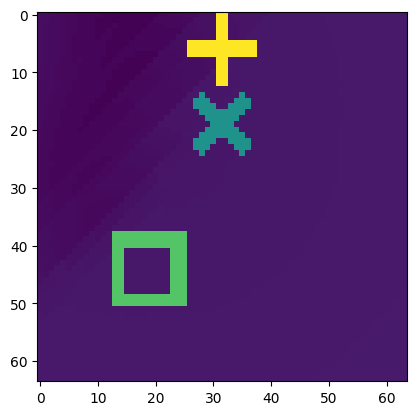

In [35]:
plt.imshow(state.transpose(1, 2, 0))

In [36]:
torch.tensor(np.array(state)).unsqueeze(0).shape

torch.Size([1, 1, 64, 64])

In [37]:
next_state, reward, is_done, _ = env.step(env.action_space.sample())

In [38]:
next_state.shape

(1, 64, 64)

In [39]:
reward

-0.01

In [40]:
is_done

False

In [41]:
SEED = 77

In [42]:
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
net = RainbowDQN(input_shape=OBS_DIM, n_actions=N_ACTIONS).to(device)

In [44]:
net(torch.tensor(state).unsqueeze(0).to(device))

tensor([[-0.0545,  0.0035, -0.0700, -0.0649, -0.0612]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [46]:
exp_buffer = NStepPriorityReplayBuffer(
    max_size=150000,
    prob_alpha=0.6,
    beta_start=0.4,
    beta_frames=200000,
    n_step=4,
    gamma=0.99,
)

In [47]:
agent = Agent(
    env=env,
    exp_buffer=exp_buffer,
    net=net,
    epsilon_start=0.9,
    epsilon_final=0.4,
    epsilon_decay_last_step=200000,
    tgt_sync_steps=5000,
    learning_rate=1e-4,
    device=device
)

In [48]:
agent.initial_exploration(n_steps=10000)

In [49]:
states, actions, rewards, dones, next_states = zip(*agent._exp_buffer._buf)

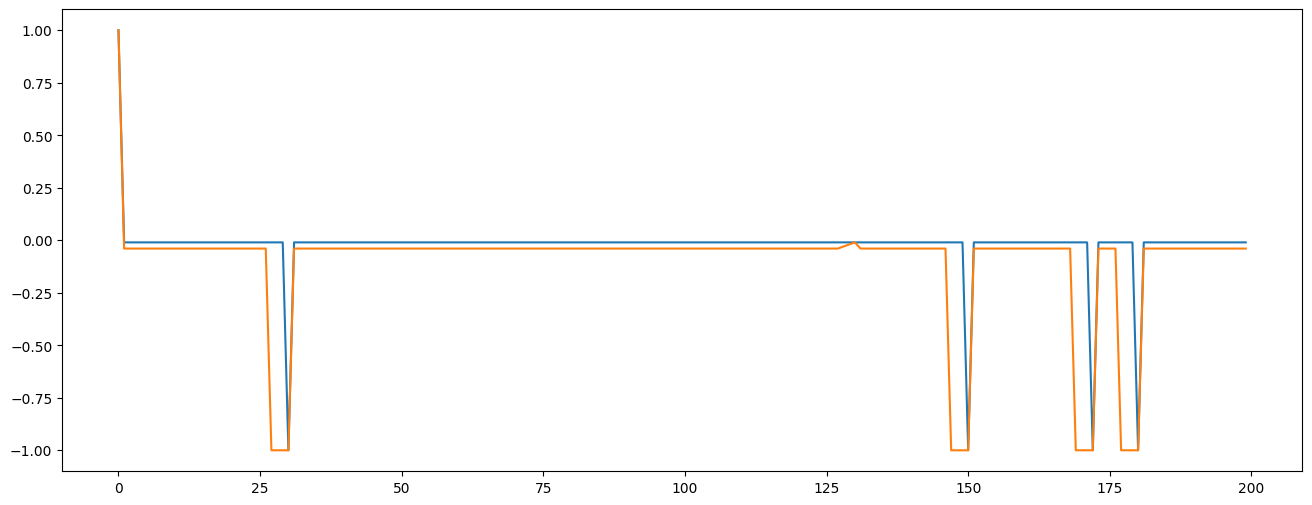

In [50]:
plt.figure(figsize=(16, 6))
plt.plot(rewards[:200])
plt.plot(agent._exp_buffer._total_discounted_rewards[:200])

In [53]:

# random episode epsilon

episode = 0
reward_history = []
spisode_steps_history = []
spisode_start_steps = 0
PRINT_EPISODE_INTERVAL = 10
print_episode_rewards = []
EVAL_EPISODE_INTERVAL = 50
N_EVAL_EPISODES = 20
epsilon = np.random.rand()

while True:

    for stp in range(20):
        # done_reward = agent.play_step(epsilon=epsilon)
        done_reward = agent.play_step()
        if done_reward is not None:
            episode += 1
            reward_history.append(done_reward)
            # print_episode_rewards.append(done_reward)
            spisode_steps_history.append(agent._total_step-spisode_start_steps)
            spisode_start_steps = agent._total_step
            if episode % PRINT_EPISODE_INTERVAL == 0:
                # rm = sum(print_episode_rewards) / len(print_episode_rewards)
                rm = sum(reward_history[-1000:]) / len(reward_history[-1000:])
                print(f'episode : {episode}, reward mean : {rm}, total_step : {agent._total_step}, cur_epsilon : {agent._epsilon}, cur_beta : {agent._exp_buffer._beta}')
            if episode % EVAL_EPISODE_INTERVAL == 0:
                eval_episode_rewards = []
                eval_episode_steps = []
                for i in range(N_EVAL_EPISODES):
                    reward, steps = agent.simulate_episode()
                    eval_episode_rewards.append(reward)
                    eval_episode_steps.append(steps)
                mr = sum(eval_episode_rewards) / len(eval_episode_rewards)
                ms = sum(eval_episode_steps) / len(eval_episode_steps)
                print(f'[EVAL] episode : {episode}, reward mean : {mr}, step mean : {ms}, eval_episode_rewards : {np.round(eval_episode_rewards, 3)}')
            # epsilon = np.random.rand()

    agent.train(n_iter=20, batch_size=32)

episode : 10, reward mean : -0.21699999067932368, total_step : 396, cur_epsilon : 0.89901, cur_beta : 0.40118800000000004
episode : 20, reward mean : -0.15849999198690057, total_step : 706, cur_epsilon : 0.898235, cur_beta : 0.40211800000000003
episode : 30, reward mean : -0.2139999929815531, total_step : 940, cur_epsilon : 0.8976500000000001, cur_beta : 0.40282
episode : 40, reward mean : -0.2872499924618751, total_step : 1356, cur_epsilon : 0.89661, cur_beta : 0.40406800000000004
episode : 50, reward mean : -0.10559999316930771, total_step : 1545, cur_epsilon : 0.8961375, cur_beta : 0.404635
[EVAL] episode : 50, reward mean : -0.8004999821074307, step mean : 80.25, eval_episode_rewards : [-1.   -1.01 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.    1.   -1.
 -1.   -1.   -1.   -1.   -1.   -1.   -1.    1.  ]
episode : 60, reward mean : -0.14916665997977058, total_step : 1821, cur_epsilon : 0.8954475000000001, cur_beta : 0.405463
episode : 70, reward mean : -0.18871427926101855, total_s

KeyboardInterrupt: 

In [50]:
# probabilistic decision ver
# exp_buffer = NStepPriorityReplayBuffer(
#     max_size=150000,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=200000,
#     n_step=4,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.9,
#     epsilon_final=0.02,
#     epsilon_decay_last_step=100000,
#     tgt_sync_steps=5000,
#     learning_rate=1e-4,
#     device=device
# )

episode = 0
reward_history = []
spisode_steps_history = []
spisode_start_steps = 0
PRINT_EPISODE_INTERVAL = 10
print_episode_rewards = []
EVAL_EPISODE_INTERVAL = 50
N_EVAL_EPISODES = 20

while True:

    for stp in range(20):
        done_reward = agent.play_step(probabilistic_decision=True)
        if done_reward is not None:
            episode += 1
            reward_history.append(done_reward)
            # print_episode_rewards.append(done_reward)
            spisode_steps_history.append(agent._total_step-spisode_start_steps)
            spisode_start_steps = agent._total_step
            if episode % PRINT_EPISODE_INTERVAL == 0:
                # rm = sum(print_episode_rewards) / len(print_episode_rewards)
                rm = sum(reward_history[-1000:]) / len(reward_history[-1000:])
                print(f'episode : {episode}, reward mean : {rm}, total_step : {agent._total_step}, cur_epsilon : {agent._epsilon}')
            if episode % EVAL_EPISODE_INTERVAL == 0:
                eval_episode_rewards = []
                eval_episode_steps = []
                for i in range(N_EVAL_EPISODES):
                    reward, steps = agent.simulate_episode()
                    eval_episode_rewards.append(reward)
                    eval_episode_steps.append(steps)
                mr = sum(eval_episode_rewards) / len(eval_episode_rewards)
                ms = sum(eval_episode_steps) / len(eval_episode_steps)
                print(f'[EVAL] episode : {episode}, reward mean : {mr}, step mean : {ms}, eval_episode_rewards : {np.round(eval_episode_rewards, 3)}')

    agent.train(n_iter=20, batch_size=32)

episode : 10, reward mean : -0.5319999925792217, total_step : 306, cur_epsilon : 0.8973072
episode : 20, reward mean : -0.25649999314919114, total_step : 596, cur_epsilon : 0.8947552
episode : 30, reward mean : -0.41933332694073516, total_step : 850, cur_epsilon : 0.89252
episode : 40, reward mean : -0.4819999925792217, total_step : 1330, cur_epsilon : 0.888296
episode : 50, reward mean : -0.39499999295920135, total_step : 1587, cur_epsilon : 0.8860344
[EVAL] episode : 50, reward mean : -0.5494999832473695, step mean : 75.25, eval_episode_rewards : [-1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.    0.98 -1.   -1.    0.99
  0.99 -1.   -1.   -1.03  1.    0.08 -1.   -1.  ]
episode : 60, reward mean : -0.38599999360740184, total_step : 1738, cur_epsilon : 0.8847056
episode : 70, reward mean : -0.39485713658588273, total_step : 1996, cur_epsilon : 0.8824352
episode : 80, reward mean : -0.4401249937945977, total_step : 2262, cur_epsilon : 0.8800944
episode : 90, reward mean : -0.4211111049271

KeyboardInterrupt: 

In [50]:
# exp_buffer = NStepPriorityReplayBuffer(
#     max_size=150000,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=500000,
#     n_step=4,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.9,
#     epsilon_final=0.45,
#     epsilon_decay_last_step=200000,
#     tgt_sync_steps=5000,
#     learning_rate=1e-4,
#     device=device
# )


episode = 0
reward_history = []
spisode_steps_history = []
spisode_start_steps = 0
PRINT_EPISODE_INTERVAL = 10
print_episode_rewards = []
EVAL_EPISODE_INTERVAL = 50
N_EVAL_EPISODES = 20

while True:

    for stp in range(20):
        done_reward = agent.play_step()
        if done_reward is not None:
            episode += 1
            reward_history.append(done_reward)
            print_episode_rewards.append(done_reward)
            spisode_steps_history.append(agent._total_step-spisode_start_steps)
            spisode_start_steps = agent._total_step
            if episode % PRINT_EPISODE_INTERVAL == 0:
                rm = sum(print_episode_rewards) / len(print_episode_rewards)
                # rm = sum(reward_history[-1000:]) / len(reward_history[-1000:])
                print(f'episode : {episode}, reward mean : {rm}, total_step : {agent._total_step}, cur_epsilon : {agent._epsilon}')
            if episode % EVAL_EPISODE_INTERVAL == 0:
                eval_episode_rewards = []
                eval_episode_steps = []
                for i in range(N_EVAL_EPISODES):
                    reward, steps = agent.simulate_episode()
                    eval_episode_rewards.append(reward)
                    eval_episode_steps.append(steps)
                mr = sum(eval_episode_rewards) / len(eval_episode_rewards)
                ms = sum(eval_episode_steps) / len(eval_episode_steps)
                print(f'[EVAL] episode : {episode}, reward mean : {mr}, step mean : {ms}, eval_episode_rewards : {np.round(eval_episode_rewards, 3)}')

    agent.train(n_iter=20, batch_size=32)

episode : 10, reward mean : 0.02800000607967377, total_step : 278, cur_epsilon : 0.89861
episode : 20, reward mean : -0.2959999945014715, total_step : 508, cur_epsilon : 0.89746
episode : 30, reward mean : -0.341333327939113, total_step : 750, cur_epsilon : 0.89625
episode : 40, reward mean : -0.4169999945908785, total_step : 1004, cur_epsilon : 0.89498
episode : 50, reward mean : -0.42519999362528327, total_step : 1470, cur_epsilon : 0.89265
[EVAL] episode : 50, reward mean : -0.36999999061226846, step mean : 42.95, eval_episode_rewards : [ 0.75  0.62  0.73  0.69 -1.42 -1.84  0.96 -1.   -1.68 -1.87 -1.27 -1.27
  0.24 -1.22  0.29  0.99  0.92  0.96 -1.98 -1.  ]
episode : 60, reward mean : -0.42933332671721774, total_step : 1829, cur_epsilon : 0.8908550000000001
episode : 70, reward mean : -0.45914285039263114, total_step : 2176, cur_epsilon : 0.88912
episode : 80, reward mean : -0.4294999934732914, total_step : 2408, cur_epsilon : 0.88796
episode : 90, reward mean : -0.37444443781342773

KeyboardInterrupt: 

<AxesSubplot: >

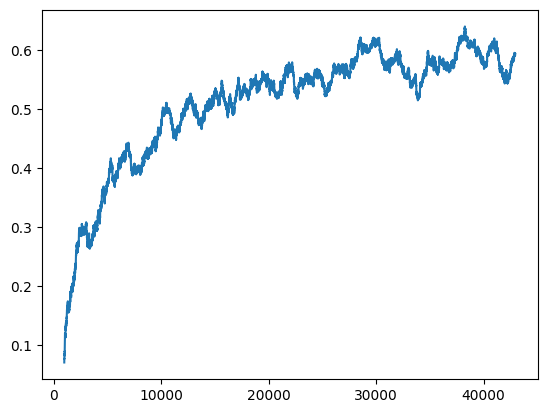

In [53]:
pd.Series(reward_history).rolling(window=1000).mean().plot()

In [76]:
# exp_buffer = NStepPriorityReplayBuffer(
#     max_size=30000,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=500000,
#     n_step=4,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.9,
#     epsilon_final=0.05,
#     epsilon_decay_last_step=1000000,
#     tgt_sync_steps=5000,
#     learning_rate=1e-4,
#     device=device
# )

episode = 0
reward_history = []
spisode_steps_history = []
spisode_start_steps = 0
PRINT_EPISODE_INTERVAL = 10
print_episode_rewards = []
EVAL_EPISODE_INTERVAL = 50
N_EVAL_EPISODES = 5

while True:

    for stp in range(20):
        done_reward = agent.play_step()
        if done_reward is not None:
            episode += 1
            reward_history.append(done_reward)
            print_episode_rewards.append(done_reward)
            spisode_steps_history.append(agent._total_step-spisode_start_steps)
            spisode_start_steps = agent._total_step
            if episode % PRINT_EPISODE_INTERVAL == 0:
                rm = sum(print_episode_rewards) / len(print_episode_rewards)
                print(f'episode : {episode}, reward mean : {rm}, total_step : {agent._total_step}, cur_epsilon : {agent._epsilon}')
            if episode % EVAL_EPISODE_INTERVAL == 0:
                eval_episode_rewards = []
                eval_episode_steps = []
                for i in range(N_EVAL_EPISODES):
                    reward, steps = agent.simulate_episode()
                    eval_episode_rewards.append(reward)
                    eval_episode_steps.append(steps)
                mr = sum(eval_episode_rewards) / len(eval_episode_rewards)
                ms = sum(eval_episode_steps) / len(eval_episode_steps)
                print(f'[EVAL] episode : {episode}, reward mean : {mr}, step mean : {ms},')

    agent.train(n_iter=20, batch_size=32)

episode : 10, reward mean : 0.305000008828938, total_step : 404, cur_epsilon : 0.8995960000000001
episode : 20, reward mean : -0.0814999925903976, total_step : 680, cur_epsilon : 0.89932
episode : 30, reward mean : -0.05499999355524778, total_step : 892, cur_epsilon : 0.899108
episode : 40, reward mean : -0.0232499944511801, total_step : 1030, cur_epsilon : 0.89897
episode : 50, reward mean : -0.08819999400526285, total_step : 1386, cur_epsilon : 0.898614
[EVAL] episode : 50, reward mean : 0.0660000029951334, step mean : 14.4,
episode : 60, reward mean : -0.10699999425560236, total_step : 1597, cur_epsilon : 0.8984030000000001
episode : 70, reward mean : -0.03757142294198275, total_step : 1828, cur_epsilon : 0.898172
episode : 80, reward mean : -0.09024999435059726, total_step : 2097, cur_epsilon : 0.897903
episode : 90, reward mean : -0.07344443858083752, total_step : 2446, cur_epsilon : 0.8975540000000001
episode : 100, reward mean : -0.07709999380633235, total_step : 2863, cur_epsil

KeyboardInterrupt: 

In [50]:
# exp_buffer = NStepPriorityReplayBuffer(
#     max_size=30000,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=50000, #100000,
#     n_step=4,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.7,
#     epsilon_final=0.01,
#     epsilon_decay_last_step=50000, #200000,
#     tgt_sync_steps=1000,
#     learning_rate=1e-4,
#     device=device
# )

episode = 0
reward_history = []
spisode_steps_history = []
spisode_start_steps = 0

while True:

    for stp in range(20):
        done_reward = agent.play_step()
        if done_reward is not None:
            print(f'episode : {episode}, done reward : {done_reward}, total_step : {agent._total_step}, cur_epsilon : {agent._epsilon}')
            episode += 1
            reward_history.append(done_reward)
            spisode_steps_history.append(agent._total_step-spisode_start_steps)
            spisode_start_steps = agent._total_step

    agent.train(n_iter=20, batch_size=32)

episode : 0, done reward : 0.6300000082701445, total_step : 1, cur_epsilon : 0.6999799999999999
episode : 1, done reward : 0.9100000020116568, total_step : 11, cur_epsilon : 0.69978
episode : 2, done reward : 0.09000002034008503, total_step : 103, cur_epsilon : 0.69794
episode : 3, done reward : 0.9900000002235174, total_step : 105, cur_epsilon : 0.6979
episode : 4, done reward : 0.9600000008940697, total_step : 110, cur_epsilon : 0.6978
episode : 5, done reward : 0.3200000151991844, total_step : 179, cur_epsilon : 0.6964199999999999
episode : 6, done reward : 0.9300000015646219, total_step : 187, cur_epsilon : 0.69626
episode : 7, done reward : 0.8300000037997961, total_step : 205, cur_epsilon : 0.6959
episode : 8, done reward : -0.9999999776482582, total_step : 305, cur_epsilon : 0.6939
episode : 9, done reward : 0.8200000040233135, total_step : 324, cur_epsilon : 0.6935199999999999
episode : 10, done reward : 0.9600000008940697, total_step : 329, cur_epsilon : 0.6934199999999999
epi

KeyboardInterrupt: 

Text(0, 0.5, 'episode total reward')

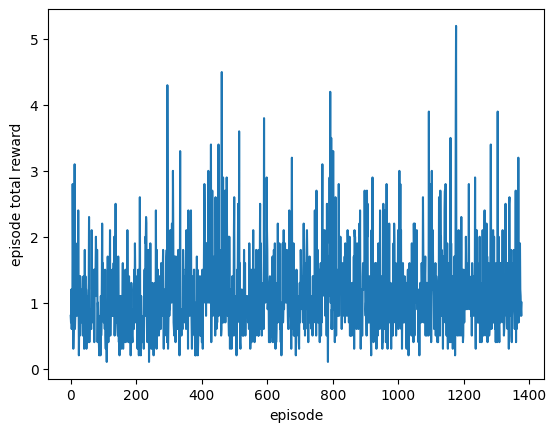

In [136]:
plt.plot(reward_history)
plt.xlabel('episode')
plt.ylabel('episode total reward')

Text(0, 0.5, 'episode steps')

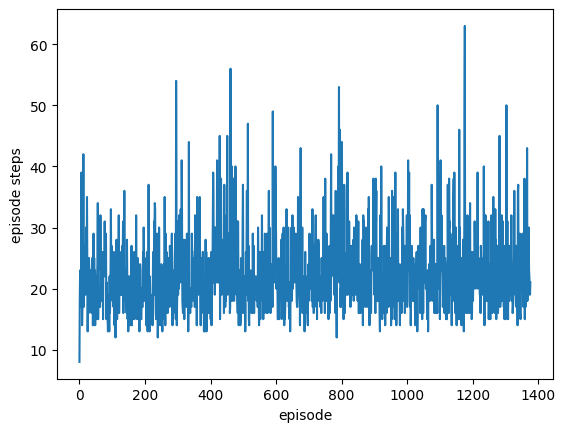

In [137]:
plt.plot(spisode_steps_history)
plt.xlabel('episode')
plt.ylabel('episode steps')

In [51]:
net(torch.tensor(state).unsqueeze(0).to(device))

tensor([[1.3680, 1.2494, 1.4766, 1.3485, 1.3401]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [51]:
env.close()